In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import collections

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from numpy import interp
from scipy.interpolate import interp1d

# Use the RWinOut instead of rpy2.ipython to get output on windows 
# https://bitbucket.org/rpy2/rpy2/issues/125/set_writeconsole-not-working-on-windows
# https://github.com/vitorcurtis/RWinOut
#%load_ext RWinOut
%load_ext rpy2.ipython

%matplotlib inline

In [2]:
# %load import_notebook.py
# Infraestructure to import a Jupyter notebook
# http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
from LogRegUtils import LogRegModel
from LogRegUtils import caldis, calibration_table, calibration, calibration2
from LogRegUtils import create_plots

importing Jupyter notebook from LogRegUtils.ipynb


### Setup

In [4]:
sel_model = 1

risk_threshold = 0.5

make_plots = True

if sel_model == 1:
    model_name = 'model-age-ct-symp'
elif sel_model == 2:
    model_name = 'model-age-symp'

In [5]:
drc_data_file = 'drc-data.csv'
drc_data = pd.read_csv(drc_data_file, na_values="\\N")

out_var = 'S7.FinalStatus'

var_dict = {
  'Death':out_var,
  'PatientAge':'AD.Age',
#   'CT':'Lab.CtGP.D1',
  'CT':'Lab.CtNP.D1',
#   'CT':'CT',
  'AnyBleeding':'S2.Bleeding',
  'Diarrhoea':'S2.Diarrhea',
  'Breathlessness':'S2.DifficultyBreathing', 
  'SwallowingProblems':'S2.DifficultySwallowing', 
  'Anorexia':'S2.AppetiteLoss',
  'BoneMusclePain':'S2.MusclePain',
}

In [6]:
model_params = os.path.join(model_name, 'model.csv')
model = LogRegModel(model_params)

predictors = model.getPredictors()

variables = [out_var] + [var_dict[var] for var in predictors]

test_data = drc_data[variables]
complete_data = test_data.dropna()
print(complete_data)

    S7.FinalStatus  AD.Age  Lab.CtNP.D1  S2.Bleeding  S2.Diarrhea  \
0              0.0  13.000         27.2            0            1   
1              1.0  14.000         18.5            1            1   
2              1.0   5.000         18.1            1            1   
3              1.0  10.000         15.8            0            1   
4              0.0   0.250         18.7            0            0   
..             ...     ...          ...          ...          ...   
92             1.0  17.000         20.5            0            0   
93             0.0   0.167         22.1            0            0   
94             0.0   1.000         18.5            0            0   
95             1.0  13.000         16.6            0            0   
96             1.0   0.580         19.1            0            0   

    S2.DifficultyBreathing  S2.DifficultySwallowing  S2.AppetiteLoss  \
0                        0                        0                1   
1                        1 

### Performance on complete data

In [7]:
x = complete_data[complete_data.columns[1:]].values
ytrue = [int(v) for v in complete_data[complete_data.columns[0]].values]
probs = model.predict(x)
ypred = [int(risk_threshold < p) for p in probs]

auc = roc_auc_score(ytrue, probs)
fpr, tpr, thresholds = roc_curve(ytrue, probs) 
brier = brier_score_loss(ytrue, probs)
cal, dis = caldis(ytrue, probs)
acc = accuracy_score(ytrue, ypred)
precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

P = N = 0
TP = TN = 0
FP = FN = 0
for i in range(len(ytrue)):
    if ytrue[i] == 1:
        P += 1
        if ypred[i] == 1: TP += 1
        else: FN += 1
    else:
        N += 1
        if ypred[i] == 0: TN += 1
        else: FP += 1
            
sens = float(TP)/P
spec = float(TN)/N

# Positive and Negative Predictive Values
# https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values
ppv = float(TP) / (TP + FP)
npv = float(TN) / (TN + FN)
        
# Likelihood ratios
# https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing
lr_pos = sens / (1 - spec) if spec < 1 else np.inf
lr_neg = (1 - sens) / spec if 0 < spec else np.inf
    
# print "True outcomes:", ytrue
# print "Prediction   :", ypred
cfr = 100 * (float(np.sum(ytrue)) / len(ytrue))
print("Number of cases :", len(ytrue)) 
print("Number of deaths:", np.sum(ytrue)) 
print("CFR             : %0.2f" % cfr)

print("") 
print("Measures of performance") 
print("AUC           : %0.2f" % auc) 
print("Brier         : %0.2f" % brier) 
# print("Calibration   :", cal) 
# print("Discrimination:", dis) 
print("Accuracy      : %0.2f" % acc) 
print("Sensitivity   : %0.2f" % sens) 
print("Specificity   : %0.2f" % spec) 
print("PPV           : %0.2f" % ppv)
print("NPV           : %0.2f" % npv)
# print("LR+           :", lr_pos)
# print("LR-           :", lr_neg)

with open(os.path.join(model_name, 'goal-validation.txt'), 'w') as of:
    of.write("Measures of performance\n")
    of.write("AUC           : %0.2f\n" % auc)
    of.write("Brier         : %0.2f\n" % brier)
#     of.write("Calibration   : " + str(cal) + "\n")
#     of.write("Discrimination: " + str(dis) + "\n")
    of.write("Accuracy      : %0.2f\n" % acc)
    of.write("Sensitivity   : %0.2f\n" % sens)
    of.write("Specificity   : %0.2f\n" % spec)
    of.write("PPV           : %0.2f\n" % ppv)
    of.write("NPV           : %0.2f\n" % npv)
#     of.write("LR+           : " + str(lr_pos) + "\n")
#     of.write("LR-           : " + str(lr_neg) + "\n")    

Number of cases : 88
Number of deaths: 52
CFR             : 59.09

Measures of performance
AUC           : 0.76
Brier         : 0.19
Accuracy      : 0.74
Sensitivity   : 0.87
Specificity   : 0.56
PPV           : 0.74
NPV           : 0.74


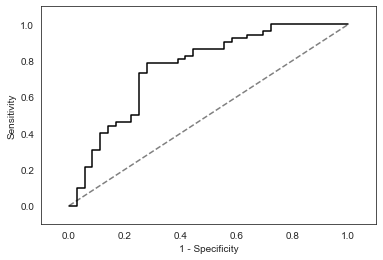

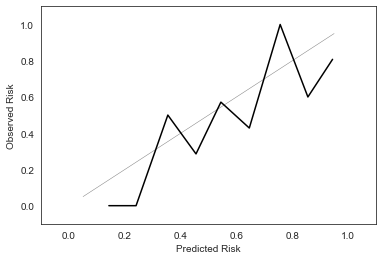

In [8]:
if make_plots:
    fig, ax = plt.subplots()
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.plot([0, 1], [0, 1], 'k--', c='grey')
    plt.plot(fpr, tpr, color='black')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    fig.savefig(os.path.join(model_name, 'goal-roc-complete.pdf'))

    cal_table = calibration_table(ytrue, probs, 10)
    fig, ax = plt.subplots()
    plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')
    x = cal_table['pred_prob']
    y = cal_table['true_prob']
    # f = interp1d(x, y, kind='cubic')
    # xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
    # plt.plot(xnew, f(xnew))
    plt.plot(x, y, color='black')
    fig.savefig(os.path.join(model_name, 'goal-cal-complete.pdf'))